# PHYS305 project: Statistical analysis of small signals

Explore statistical inference of small signals in a realistic physics experiment simulation.

Project objectives:
- Understand statistical inference with low-count Poisson statistics and the construction of confidence intervals.
- Develop code to compute classical central and upper confidence intervals, as well as and Feldman-Cousins confidence limits based on the likelihood ratio ranking principle.
- Compare the different types of confidence intervals and their frequentist coverahe properties.
- Compute upper-limit confidence intervals for cases where no signal events are observed.
- Apply these methods to a simulated counting experiment 

The code and examples below are a starting point for further exploration.

*For enquiries, e-mail **Prof. Costas Andreopoulos** <c.andreopoulos @ cern.ch>*

In [1]:
import time
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.optimize import bisect
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# pd.set_option("display.max_rows", None)

## Construction of confidence intervals

Assume that $n$ is an observable, and that the probability density function for $n$ depends on the unknown value of a parameter $\mu$. A typical problem in science is the estimation of the value of $\mu$ from a measurement of $n$.

Classical confidence intervals $[\mu_\ell,\mu_h]$ are an objective way of summarizing the results of an experiment, and they have the property that 

$P(\mu \in [\mu_\ell,\mu_h])=\alpha$

where $\alpha$ is the confidence level. The above property should not be taken to mean that the true value $\mu^\star$ of the unknown parameter $\mu$ is in the range $[\mu_\ell,\mu_h]$ with a probability of $\alpha$. A confidence interval is not a statement about the true value of $\mu$ derived from the posterior probability $P(\mu|n)$. Rather, it is a statement about the observation $n$ derived from the likelihood function $P(n|\mu)$. It means that if I was to run my experiment $N$ times, derive an estimate $\hat{\mu}$ of the value of $\mu$, and construct a confidence interval at confidence level $\alpha$ for each such experiment, then approximately $\alpha N$ of these experiments will contain the true value $\mu^\star$ in the quoted confidence region. This statement is true irrespective of the value of $\mu^\star$.

The starting point for the construction of a classical confidence interval, is the calculation of acceptance regions. An acceptance region $[x_\ell, x_h]$, for a fixed value of $\mu$, is an interval with the property that

$P(n \in [n_\ell,n_h]|\mu)=\alpha$

For a given value of $\mu$, there are many possible intervals that satisfy this property.

To fully specify the acceptance region,

- $P(n < n_\ell|\mu)=1-\alpha$, leading to the construction of classical upper limits, and
- $P(n < n_\ell|\mu)=P(n > n_h|\mu)=(1-\alpha)/2$, leading to the construction of classical central limits.

Another option is to select values of $n$ in the acceptance region by ranking them according to the likelihood ratio $R$, defined as

$R=P(n|\mu)/P(n|\hat{\mu})$

where $\hat{\mu}$ is the best-fit estimate of $\mu$ that maximizes $P(n|\mu)$ (referred to as $\mu_{best}$ in the code extracts below). The limits constructed by making this choice are commonly referred to as the Feldmann-Cousins (FC) limits \[1\]. They have the advantage of provinding confidence intervals with guaranteed coverage, and avoiding certain pathologies in special cases (e.g. empty confidence intervals). An alternative ordering principle that also aims to improev upon classical limits can be found in \[2\].

## Code for the calculation of confidence intervals

### Calculation of acceptance intervals for the construction of confidence limits

The following function builds a table similar to Table I shown in reference \[1\].
This is a calculation of the acceptance interval for a given signal mean in the presence of a known background.
The acceptance interval is calculated for the FC confidence limit construction, as well as for the construction of standard upper limits (UL) and central limits.

The code produces a DataFrame with rows corresponding to n values in the range [0, nmax) and with the following columns:
- **`P(n|mu)'**: Conditional probability to observe n events for the given mean signal mu.
- **'mu_best'**: The value of the mean signal that maximises P(n|mu).
- **'P(n|mu_best)'**: Conditional probability to observe n events for the mean signal mu_best.
- **'R'**: The likelihood ratio P(n|mu)/P(n|mu_best).          
- **'Rank'**: The order with which values of n are added in the FC acceptance region for the given mu.      
- **'FC'**: Boolean flag indicating whether the current n belongs in the acceptance region for a FC limit.
- **'UL'**: Boolean flag indicating whether the current n belongs in the acceptance region for a classical UL.
- **'Central'**: Boolean flag indicating whether the current n belongs in the acceptance region for a classical central limit.

The code expects the following inputs:
- **conf_level**: Desired confidence level \in (0,1)
- **mu_sig**: Mean signal
- **mu_bkg**: Mean background
- **nmax**: Defines the number of rows in the output data frame


In [2]:
def acceptance_region(conf_level, mu_sig, mu_bkg, nmax=0):
    """
    Calculate acceptance intervals for the construction of confidence intervals, 
    for a given signal mean in the presence of a known background. 
    The code returns a DataFrame reproducing Table I in Feldmann and Cousins, Phys.Rev.D 57 (1998) 3873.
    """

    # If nmax was not set, use a safe large value
    if(nmax<=0):
        nmax = 20 * int(mu_sig+mu_bkg+1)
        
    # Define a data frame with a structure similar to that of
    # Table I in the Feldman and Cousins paper
    dframe = pd.DataFrame(\
        {\
        'P(n|mu)'      : np.zeros(nmax), \
        'mu_best'      : np.zeros(nmax), \
        'P(n|mu_best)' : np.zeros(nmax), \
        'R'            : np.zeros(nmax), \
        'Rank'         : np.zeros(nmax, dtype=int), \
        'FC'           : np.full((nmax),False,dtype=bool), \
        'Upper'        : np.full((nmax),False,dtype=bool), \
        'Central'      : np.full((nmax),False,dtype=bool)  \
        }\
    )
    dframe.index.name = 'n'
    n_arr  = dframe.index # allowed range of values for the observed number of events 

    # Calculate the Poisson p.m.f. P(n|μ), where μ is the expected number of (signal+bkg) events
    dframe['P(n|mu)'] = poisson.pmf(n_arr, mu_sig+mu_bkg)

    # Calculate best estimate for the signal events (subtract the background)
    dframe['mu_best'] = np.maximum(0, n_arr - mu_bkg)

    # Calculate the Poisson p.m.f. P(n|μ_best)
    dframe['P(n|mu_best)'] = poisson.pmf(n_arr, dframe['mu_best']+mu_bkg)

    # Calculate the likelihood ratio R
    dframe['R'] = dframe['P(n|mu)']/dframe['P(n|mu_best)']

    #
    # Find the range of n values in the FC confidence belt for the given μ
    # 
    
    # Get the values of n in descending order of R
    fc_n_ranking = np.argsort(dframe['R'].values)[::-1] 
    # print (fc_n_ranking)

    # Compute the ranking index:
    # Do this by finding the index of each value of n in the above array and adding 1.
    fc_n_ranking_index = np.argsort(fc_n_ranking) + 1
    # print(fc_n_ranking_index)

    # Store the ranking index in the data frame
    dframe['Rank'] = fc_n_ranking_index

    # Get the cumulative sum of the array of P(n|μ) values in descending order of R
    cs = dframe['P(n|mu)'].values[fc_n_ranking].cumsum()
    # Find the slot of the above cumulative sum array that includes CL% of the 
    # probabilty (+1 to avoid undercoverage because of the discreteness of steps).
    fc_n_ranking_index_max = np.searchsorted(cs,conf_level)+1
    # Store a boolean list that marks all n indices up to and including that slot.        
    dframe['FC'] = (fc_n_ranking_index <= fc_n_ranking_index_max)

    #
    # Find the range of n values in a standard upper limit
    # 

    # Get the cumulative sum of the array with the P(n|μ) values.
    cs_f = dframe['P(n|mu)'].values.cumsum()
    # For an upper limit, find the [n,\infty] range with integrated probability >= 1-CL
    dframe['Upper'] = (cs_f >= 1-conf_level)

    #
    # Find the range of n values in a standard central limit
    # 

    # Get the cumulative sum of the P(n|μ) array in both the forward and reverse direction.
    cs_f = dframe['P(n|mu)'].values.cumsum()
    cs_r = dframe['P(n|mu)'].values[::-1].cumsum()[::-1]

    # For a central limit, find the [0,n] and [n,\infty] ranges with 
    # integrated probability >= (1-CL)/2 and then calculate the union of the two ranges
    range_hi = (cs_f >= (1-conf_level)/2) # [n,\infty] range with integrated probability >= (1-CL)/2 
    range_lo = (cs_r >= (1-conf_level)/2) # [0, n]     range with integrated probability >= (1-CL)/2 
    dframe['Central'] = np.logical_and(range_lo,range_hi)

    return dframe;

In [3]:
# Test the acceptance_region() function.
# Produce and print a table similar to Table I in Phys.Rev.D 57 (1998) 3873

mu_sig     = 0.5
mu_bkg     = 3.0
conf_level = 0.9

print(f"Printing the {conf_level*100}% C.L. acceptance regions for mu_sig = {mu_sig}, mu_bkg = {mu_bkg}\n") 
reg = acceptance_region(conf_level,mu_sig,mu_bkg,15)
print(reg)

Printing the 90.0% C.L. acceptance regions for mu_sig = 0.5, mu_bkg = 3.0

     P(n|mu)  mu_best  P(n|mu_best)         R  Rank     FC  Upper  Central
n                                                                         
0   0.030197      0.0      0.049787  0.606531     6   True  False    False
1   0.105691      0.0      0.149361  0.707619     5   True   True     True
2   0.184959      0.0      0.224042  0.825556     3   True   True     True
3   0.215785      0.0      0.224042  0.963148     2   True   True     True
4   0.188812      1.0      0.195367  0.966450     1   True   True     True
5   0.132169      2.0      0.175467  0.753237     4   True   True     True
6   0.077098      3.0      0.160623  0.479995     7   True   True     True
7   0.038549      4.0      0.149003  0.258714     8  False   True     True
8   0.016865      5.0      0.139587  0.120823     9  False   True    False
9   0.006559      6.0      0.131756  0.049779    10  False   True    False
10  0.002296      7.0    

### Construction of confidence belts

The following function computes a *confidence belt*, i.e. a table that describes the acceptance region \[n_min, n_max\] for a range of values of the signal mean mu.

The code produces a DataFrame with rows corresponding to signal mean mu and with two columns:
- **`n_min'**: the minimum, and
- **`n_max'**: the maximum
number of events in the acceptance region for the given value of mu.

The code expects the following inputs:
- **conf_level**: Desired confidence level \in (0,1)
- **limit_type**: The type of CL (options: "FC", "Central", "Upper")
- **mu_sig_arr**: An array of mean signal values
- **mu_bkg**: Mean background (taken to be constant)

In [4]:
def confidence_belt(conf_level, limit_type, mu_sig_arr, mu_bkg):

    """
    Computes a confidence belt, i.e. return a table (DataFrame) that describes the 
    acceptance region [n_min, n_max] for a range of values of the signal mean mu.
    """
    # Find the number of signal mean values in the input array
    nrows = mu_sig_arr.size

    # Define the output data frame, as described in the comments above
    dframe = pd.DataFrame(\
        {\
        'n_min' : np.zeros(nrows), \
        'n_max' : np.zeros(nrows), \
        }, \
        index = mu_sig_arr \
    )
    dframe.index.name = 'mu'

    # For each signal mean value in the array, call acceptance_region()
    # and extract the [n_min, n_max] range 
    for i, mu_sig in enumerate(mu_sig_arr):
        acreg = acceptance_region(conf_level, mu_sig, mu_bkg)
        # Get all the values of n, where the entry in the boolean column 
        # corresponding to the input type of limits is True
        interval = acreg.index.values[acreg[limit_type]]
        # Find the min and max value of n on the array (special case: empty interval)
        n_min = np.min(interval) if len(interval) > 0 else 0
        n_max = np.max(interval) if len(interval) > 0 else 0    
        dframe.loc[mu_sig].n_min = n_min
        dframe.loc[mu_sig].n_max = n_max

    return dframe

Printing the 90.0% C.L. confidence belts for mu_sig in [0.0,9.5] and mu_bkg = 3.0

     n_min_FC  n_max_FC  n_min_C  n_max_C  n_min_U  n_max_U
mu                                                         
0.0       0.0       5.0      1.0      6.0      1.0     79.0
0.5       0.0       6.0      1.0      7.0      1.0     79.0
1.0       1.0       7.0      1.0      8.0      2.0     99.0
1.5       1.0       7.0      1.0      8.0      2.0     99.0
2.0       2.0       9.0      2.0      9.0      2.0    119.0
2.5       2.0       9.0      2.0     10.0      3.0    119.0
3.0       2.0      10.0      2.0     10.0      3.0    139.0
3.5       3.0      11.0      3.0     11.0      3.0    139.0
4.0       3.0      11.0      3.0     12.0      4.0    159.0
4.5       4.0      13.0      3.0     12.0      4.0    159.0
5.0       4.0      13.0      4.0     13.0      5.0    179.0
5.5       4.0      13.0      4.0     14.0      5.0    179.0
6.0       5.0      14.0      4.0     14.0      5.0    199.0
6.5       5.0    

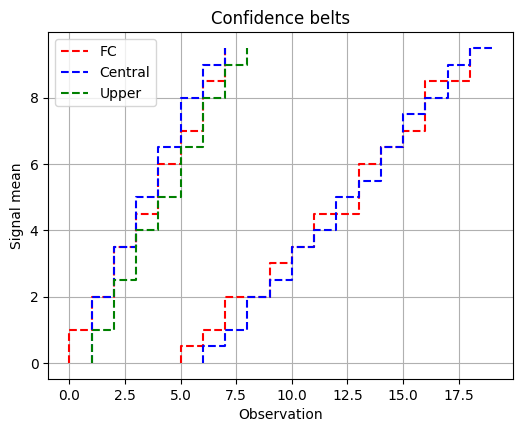

In [5]:
# Test the confidence_belt() function.
# Construct and print/plot F.C., U.L and central confidence belts for a given C.L.,
# a given range of signal means, and a given (constant) background mean. 
# Produce plots similar to the ones shown in Figs. 5,6,7 in Phys.Rev.D 57 (1998) 3873.

# Specify inputs
conf_level = 0.9
mu_sig_arr = np.arange(0,10,.5)
mu_bkg     = 3.0

print(f"Printing the {conf_level*100}% C.L. confidence belts for "
      f"mu_sig in [{mu_sig_arr[0]},{mu_sig_arr[-1]}] and mu_bkg = {mu_bkg}\n") 

# Generate confidence belts, for different types of limits, as Pandas DataFrames
belt_fc = confidence_belt(conf_level, "FC",      mu_sig_arr, mu_bkg)
belt_cl = confidence_belt(conf_level, "Central", mu_sig_arr, mu_bkg)
belt_ul = confidence_belt(conf_level, "Upper",   mu_sig_arr, mu_bkg)

# Merge the 3 frames side-by-side (axis=1) and add a suffix to the column labels
merged_table = pd.concat(
    [belt_fc.add_suffix("_FC"), belt_cl.add_suffix("_C"), belt_ul.add_suffix("_U")], 
    axis=1)
print(merged_table)

# Draw the 3 sets (FC, central, UL) of confidence belts
plt.figure(figsize=(6, 4.5))
plt.step(belt_fc.n_min.values,mu_sig_arr,"r--")
plt.step(belt_fc.n_max.values,mu_sig_arr,"r--",label="FC")
plt.step(belt_cl.n_min.values,mu_sig_arr,"b--")
plt.step(belt_cl.n_max.values,mu_sig_arr,"b--",label="Central")
plt.step(belt_ul.n_min.values,mu_sig_arr,"g--",label="Upper")
plt.grid(True)
plt.title("Confidence belts")
plt.xlabel("Observation")
plt.ylabel("Signal mean")
plt.legend()
plt.show()

### Calculation of confidence limits

The following two functions calculates the confidence limit for a Poisson process with a known background.
The function inputs are:
- **conf_level**: Desired confidence level \in (0,1).
- **limit_type**: The type of CL (options: "FC", "Central", "Upper").
- **n_obs**: The observed number of events.
- **mu_bkg**: Mean background (taken to be constant).
- **mu_accuracy**: The required accuracy in the calculation of limits.

The first function does a brute force calculation of confidence belts for a wide range of signal means $\mu$, and calculates the intersection points of the belt with the $n=n_{obs}$ line. The second function is more efficient computationally and performs a binary search to find the values of $\mu$ yielding an acceptance region $[n_{min}, n_{max}]$ with an endpoint equal to $n_{obs}$.

In [6]:
def confidence_limit(conf_level, limit_type, n_obs, mu_bkg, mu_accuracy=0.01):
    """
    Calculate confidence limit using a brute force construction of the confidence belt for a wide range of signal means
    """
    sqrtn      = max(2.,np.sqrt(n_obs+mu_bkg))    
    mu_sig_min = max(0, n_obs - 3 * sqrtn)
    mu_sig_max = n_obs + 3 * sqrtn
    mu_sig_arr = np.arange(mu_sig_min, mu_sig_max, mu_accuracy)

    # Get the confidence belt as a Pandas DataFrame.
    cbelt = confidence_belt(conf_level, limit_type, mu_sig_arr, mu_bkg)
    # print(cbelt)
    
    # Calculate a Pandas Series, where the index represents the signal mean (mu_sig)
    # the values are booleans that are True if n_min <= n <= n_max.
    mask_series = (cbelt['n_min'] <= n_obs) & (n_obs <= cbelt['n_max'])

    # Find all the positions of the mask_series where the value is True.
    indices = np.where(mask_series)[0]

    if indices.size < 1:
        return 0, 0 # empty interval
        
    # Get the values of the mean signal array (indexing the mask_series)
    # for the the selected positions returned above.
    mu_sig_arr_selected = mu_sig_arr[indices]

    # Get the confidence interval for the given n and confidence level.
    mu_sig_lower_bound = mu_sig_arr_selected[0]
    mu_sig_upper_bound = mu_sig_arr_selected[-1] 
    
    return mu_sig_lower_bound, mu_sig_upper_bound   

In [7]:
def confidence_limit_binary_search(conf_level, limit_type, n_obs, mu_bkg, mu_accuracy=0.01):
    """
    Calculate confidence limit using an efficient binary search for the signal means 
    yielding an acceptance region with an endpoint equal to the observed number of events.
    """
    # Some safe, broad range of signal means
    sqrtn = max(2.,np.sqrt(n_obs+mu_bkg))    
    mu_sig_min = max(0, n_obs - 5 * sqrtn)
    mu_sig_max = n_obs + 5 * sqrtn

    # Define functions of the signal mean, whose roots correspond to the values where the
    # acceptance region has an endpoint that aligns with the observed number of events.
    def lower_bound(mu_sig):
        acreg = acceptance_region(conf_level, mu_sig, mu_bkg)
        interval = acreg.index.values[acreg[limit_type]]
        n_max = np.max(interval) if len(interval) > 0 else 0 
        return n_max-n_obs
    def upper_bound(mu_sig):
        acreg = acceptance_region(conf_level, mu_sig, mu_bkg)
        interval = acreg.index.values[acreg[limit_type]]
        n_min = np.min(interval) if len(interval) > 0 else 0
        return n_min-n_obs

    # Determine how many decimal places to keep based on the specified accuracy level
    decimal_places = max(0, -int(np.floor(np.log10(accuracy))))
    
    # Find approximate lower and upper bounds using a binary search.
    # The bounds are approximate because of the discreteness of the problem, ie the confidence
    # belts are not smooth but resemble a ladder.
    # The lower_bound() and upper_bound() functions defined above have multiple roots and
    # the a binary search returns the first root found resulting in somewhat narrower limits

    try:
        mu_sig_lower_bound_approx = bisect(lower_bound, mu_sig_min, mu_sig_max)
    except ValueError:
        mu_sig_lower_bound_approx = 0

    try:
        mu_sig_upper_bound_approx = bisect(upper_bound, mu_sig_min, mu_sig_max)
    except ValueError:
        mu_sig_upper_bound_approx = 0

    mu_sig_lower_bound_approx = np.round(mu_sig_lower_bound_approx,decimal_places)
    mu_sig_upper_bound_approx = np.round(mu_sig_upper_bound_approx,decimal_places)

    # Starting from the approximate bounds, decrease (increase) the lower (upper) bound
    # by small steps, equal to the required accuracy of the limit calculation, till you 
    # roots yielding the widest possible interval

    step = mu_accuracy
    mu_sig_lower_bound = mu_sig_lower_bound_approx
    while mu_sig_lower_bound - step >= mu_sig_min and lower_bound(mu_sig_lower_bound - step) >= 0:
            mu_sig_lower_bound = mu_sig_lower_bound - step
    mu_sig_upper_bound = mu_sig_upper_bound_approx
    while mu_sig_upper_bound + step <= mu_sig_max and upper_bound(mu_sig_upper_bound + step) <= 0:
            mu_sig_upper_bound = mu_sig_upper_bound + step
    
    return mu_sig_lower_bound, mu_sig_upper_bound       

In [8]:
# Test confidence_limit().
# Generate and print a single confidence limit estimation for an observation with a known background.

# Specify inputs
conf_level_arr  = { 0.6827, 0.90, 0.95 }
limit_type  = "FC"
n        = 5
mu_bkg   = 3.0
accuracy = 0.01

# Determine how many decimal places to keep based on the specified accuracy level
decimal_places = max(0, -int(np.floor(np.log10(accuracy))))

print("Limits computed using a brute force construction of confidence belt for a broad range of signal means:")
start = time.perf_counter()
for conf_level in conf_level_arr:
    # Calculate and print the confidence limit 
    mu_min, mu_max = confidence_limit(conf_level,limit_type,n,mu_bkg,accuracy)
    print(f"{conf_level*100:.2f}% C.L. interval "
          f"for a measurement n = {n} with background mu_bkg = {mu_bkg}: " 
          f"[{mu_min:.{decimal_places}f},{mu_max:.{decimal_places}f}]")
end = time.perf_counter()
print(f"Elapsed time = {end-start:.6f} seconds \n")

print("Limits computed using a binary search for the signal means with an acceptance region with an endpoint at n=nobs:")
start = time.perf_counter()
for conf_level in conf_level_arr:
    # Calculate and print the confidence limit 
    mu_min, mu_max = confidence_limit_binary_search(conf_level,limit_type,n,mu_bkg,accuracy)
    print(f"{conf_level*100:.2f}% C.L. interval "
          f"for a measurement n = {n} with background mu_bkg = {mu_bkg}: " 
          f"[{mu_min:.{decimal_places}f},{mu_max:.{decimal_places}f}]")    
end = time.perf_counter()
print(f"Elapsed time = {end-start:.6f} seconds \n")    

Limits computed using a brute force construction of confidence belt for a broad range of signal means:
68.27% C.L. interval for a measurement n = 5 with background mu_bkg = 3.0: [0.45,4.80]
90.00% C.L. interval for a measurement n = 5 with background mu_bkg = 3.0: [0.00,6.98]
95.00% C.L. interval for a measurement n = 5 with background mu_bkg = 3.0: [0.00,8.25]
Elapsed time = 1.732963 seconds 

Limits computed using a binary search for the signal means with an acceptance region with an endpoint at n=nobs:
68.27% C.L. interval for a measurement n = 5 with background mu_bkg = 3.0: [0.45,4.80]
90.00% C.L. interval for a measurement n = 5 with background mu_bkg = 3.0: [0.00,6.98]
95.00% C.L. interval for a measurement n = 5 with background mu_bkg = 3.0: [0.00,8.25]
Elapsed time = 0.094469 seconds 



In [9]:
def build_table_of_limits(conf_level, limit_type, n_arr, mu_bkg_arr, accuracy):
    print(f"Building a table of {limit_type} confidence limits for the following ranges of \n"
          f"- measurements: {n_arr}, and \n"
          f"- background levels: {mu_bkg_arr} \n"
          f"This might take a while...\n")

    """
    Generate and print confidence limits for a range of observations and background levels.
    The code generates tables similar to Tables II - IX in Phys.Rev.D 57 (1998) 3873.
    """

    # Define the output data frame, as described in the comments above
    table = pd.DataFrame({}, index = n_arr)
    table.index.name = 'n'

    for mu_bkg in mu_bkg_arr:
        limits = []
        for n in n_arr:
            mu_min, mu_max = confidence_limit_binary_search(conf_level, limit_type, n, mu_bkg, accuracy)
            limits.append([mu_min, mu_max])
        column_label = f"mu_bkg={mu_bkg}"
        table[column_label] = limits

    # Determine how many decimal places to keep based on the specified accuracy level
    decimal_places = max(0, -int(np.floor(np.log10(accuracy))))
    # Function to format the lists contained in the table
    def format_list(cell):
        if isinstance(cell, list):  # Check if cell contains a list
            return [round(x, decimal_places) for x in cell]  # Keep as a list
            # return f"[{', '.join(f'{x:.{decimal_places}f}' for x in cell)}]"
        return cell  # Return unchanged if not a list
    # Apply formatting to each cell
    table_formatted = table.map(format_list)

    return table_formatted

Building a table of FC confidence limits for the following ranges of 
- measurements: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], and 
- background levels: [0.  0.5 1.  1.5 2. ] 
This might take a while...

        mu_bkg=0.0     mu_bkg=0.5     mu_bkg=1.0     mu_bkg=1.5     mu_bkg=2.0
n                                                                             
0.0    [0.0, 1.29]       [0, 0.8]      [0, 0.54]      [0, 0.31]      [0, 0.14]
1.0   [0.37, 2.75]    [0.0, 2.25]    [0.0, 1.75]      [0, 1.31]      [0, 0.96]
2.0   [0.74, 4.25]   [0.45, 3.75]   [0.15, 3.25]    [0.0, 2.75]      [0, 2.25]
3.0    [1.11, 5.3]    [0.81, 4.8]    [0.55, 4.3]    [0.32, 3.8]     [0.0, 3.3]
4.0   [2.34, 6.77]   [1.84, 6.27]   [1.34, 5.77]   [0.92, 5.27]   [0.45, 4.77]
5.0    [2.76, 7.8]    [2.26, 7.3]    [1.76, 6.8]    [1.32, 6.3]    [0.97, 5.8]
6.0   [3.83, 9.27]   [3.33, 8.77]   [2.83, 8.27]   [2.33, 7.77]   [1.83, 7.27]
7.0   [4.26, 10.3]    [3.76, 9.8]    [3.26, 9.3]    [2.76, 8.8]    [2.26, 8.3]
8.0  [5.31, 11

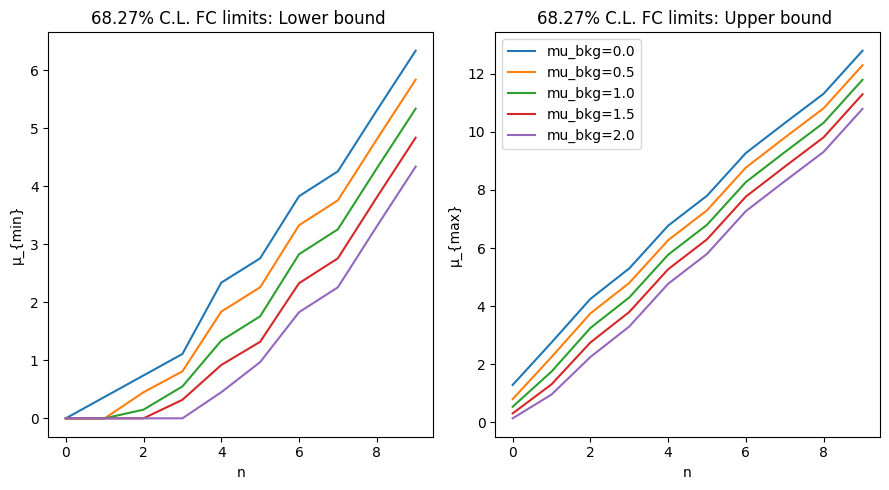

Building a table of Upper confidence limits for the following ranges of 
- measurements: Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype='float64', name='n'), and 
- background levels: [0.  0.5 1.  1.5 2. ] 
This might take a while...

     mu_bkg=0.0  mu_bkg=0.5  mu_bkg=1.0 mu_bkg=1.5 mu_bkg=2.0
n                                                            
0.0   [0, 1.14]   [0, 0.64]   [0, 0.14]     [0, 0]     [0, 0]
1.0   [0, 2.35]   [0, 1.85]   [0, 1.35]  [0, 0.85]  [0, 0.35]
2.0   [0, 3.51]   [0, 3.01]   [0, 2.51]  [0, 2.01]  [0, 1.51]
3.0   [0, 4.65]   [0, 4.15]   [0, 3.65]  [0, 3.15]  [0, 2.65]
4.0   [0, 5.76]   [0, 5.26]   [0, 4.76]  [0, 4.26]  [0, 3.76]
5.0   [0, 6.87]   [0, 6.37]   [0, 5.87]  [0, 5.37]  [0, 4.87]
6.0   [0, 7.96]   [0, 7.46]   [0, 6.96]  [0, 6.46]  [0, 5.96]
7.0   [0, 9.05]   [0, 8.55]   [0, 8.05]  [0, 7.55]  [0, 7.05]
8.0  [0, 10.13]   [0, 9.63]   [0, 9.13]  [0, 8.63]  [0, 8.13]
9.0  [0, 11.21]  [0, 10.71]  [0, 10.21]  [0, 9.71]  [0, 9.21]



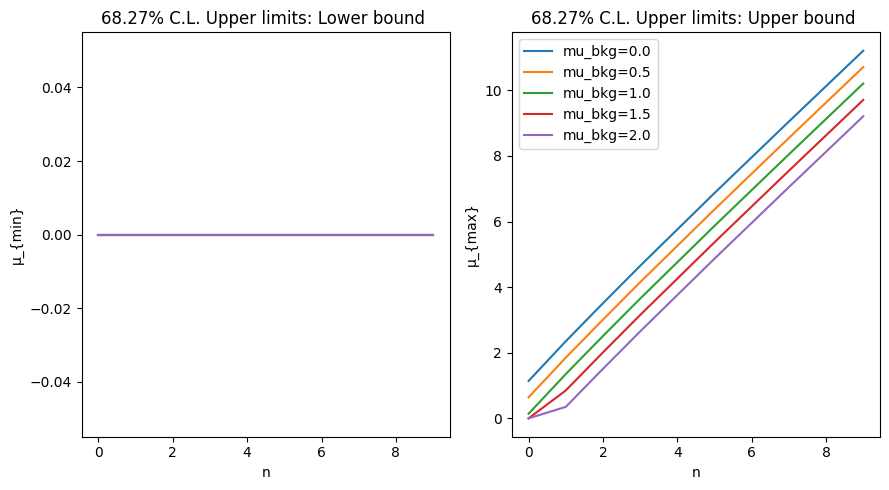

Building a table of Central confidence limits for the following ranges of 
- measurements: Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype='float64', name='n'), and 
- background levels: [0.  0.5 1.  1.5 2. ] 
This might take a while...

        mu_bkg=0.0     mu_bkg=0.5     mu_bkg=1.0     mu_bkg=1.5     mu_bkg=2.0
n                                                                             
0.0    [0.0, 1.84]      [0, 1.34]      [0, 0.84]      [0, 0.34]         [0, 0]
1.0   [0.18, 3.29]    [0.0, 2.79]      [0, 2.29]      [0, 1.79]      [0, 1.29]
2.0   [0.71, 4.63]   [0.21, 4.13]    [0.0, 3.63]      [0, 3.13]      [0, 2.63]
3.0   [1.37, 5.91]   [0.87, 5.41]   [0.37, 4.91]    [0.0, 4.41]    [0.0, 3.91]
4.0   [2.09, 7.16]   [1.59, 6.66]   [1.09, 6.16]   [0.59, 5.66]   [0.09, 5.16]
5.0   [2.85, 8.38]   [2.35, 7.88]   [1.85, 7.38]   [1.35, 6.88]   [0.85, 6.38]
6.0   [3.63, 9.58]   [3.13, 9.08]   [2.63, 8.58]   [2.13, 8.08]   [1.63, 7.58]
7.0  [4.42, 10.77]  [3.92, 10.27]  

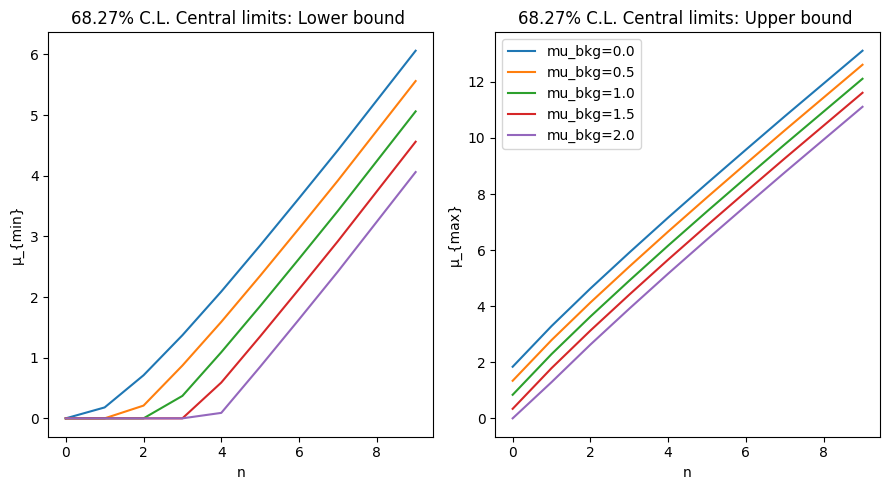

In [10]:
# Specify inputs
conf_level   = 0.6827
limit_type_list = ["FC", "Upper", "Central"]
n_arr        = np.arange(0, 10.0, 1.0)
mu_bkg_arr   = np.arange(0,  2.5, 0.5)
accuracy     = 0.01

for limit_type in limit_type_list:
    
    table = build_table_of_limits(conf_level,limit_type,n_arr,mu_bkg_arr,accuracy)
    print(f"{table}\n")

    fig = plt.figure(figsize=(9, 5))
    gs = gridspec.GridSpec(1,2, width_ratios=[1, 1])
    axL = fig.add_subplot(gs[0,0])
    axR = fig.add_subplot(gs[0,1])
    n_arr = table.index
    for col in table.columns:
        #
        mu_min_arr = table[col].apply(lambda x: x[0]).to_numpy()
        axL.set_xlabel("n")
        axL.set_ylabel("μ_{min}")
        axL.set_title(f"{conf_level*100}% C.L. {limit_type} limits: Lower bound ")
        axL.plot(n_arr, mu_min_arr, label=col) 
        #
        mu_max_arr = table[col].apply(lambda x: x[1]).to_numpy()
        axR.set_xlabel("n")
        axR.set_ylabel("μ_{max}")
        axR.set_title(f"{conf_level*100}% C.L. {limit_type} limits: Upper bound ")
        axR.plot(n_arr, mu_max_arr, label=col)        
    plt.tight_layout() # Adjust layout
    plt.legend()    
    plt.show()

## Coverage tests

Fraction of experiments where the 90.00% confidence limit includes the true mean signal:
- For true mean signal = 0.0, the fraction is 94.60% : overcoverage
- For true mean signal = 1.0, the fraction is 92.90% : overcoverage
- For true mean signal = 1.5, the fraction is 90.40% : overcoverage
- For true mean signal = 2.0, the fraction is 93.70% : overcoverage
- For true mean signal = 2.5, the fraction is 94.80% : overcoverage
- For true mean signal = 3.0, the fraction is 93.00% : overcoverage
- For true mean signal = 5.0, the fraction is 92.00% : overcoverage
- For true mean signal = 8.0, the fraction is 90.40% : overcoverage


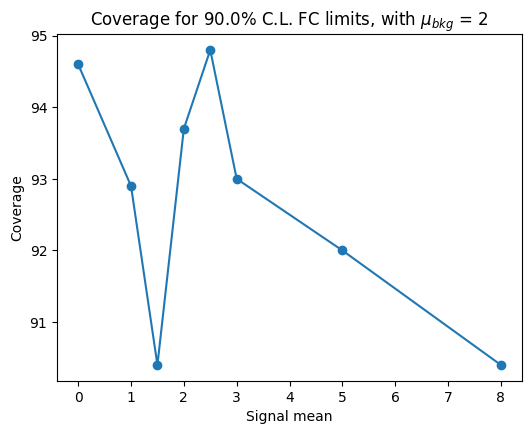

In [19]:
mu_sig_list = [ 0., 1.0, 1.5, 2.0, 2.5, 3.0, 5.0, 8.0]
mu_bkg      = 2
conf_level  = 0.90
limit_type  = "FC"
accuracy    = 0.01
n_toy_expts = 1000
seed        = None

# Random number generator
rng = np.random.default_rng(seed) 

# Vectorize the function confidence_limit() function, so it can be called with an array of observations from a number of toy experiments
vectorized_confidence_limit_binary_search = np.vectorize(confidence_limit_binary_search, otypes=[float, float])

coverage_list = [] # store the coverage for each value of signal mean

print(f"Fraction of experiments where the {100*conf_level:.2f}% confidence limit includes the true mean signal:")

for mu_sig in mu_sig_list:
    # Generate `observations' for a large number of toy experiments
    n_obs_arr = rng.poisson(lam=mu_sig+mu_bkg, size=n_toy_expts)

    # Calculate confidence limits for all toy experiments
    mu_min, mu_max = vectorized_confidence_limit_binary_search(conf_level, limit_type, n_obs_arr, mu_bkg, accuracy)

    # Count how many times the true value is within the range of the reported confidence limit
    n = np.sum((mu_min <= mu_sig) & (mu_sig <= mu_max))

    coverage = 100*n/n_toy_expts
    print(f"- For true mean signal = {mu_sig}, the fraction is {coverage:.2f}% "
          f"{': ** undercoverage **' if coverage < conf_level else ': overcoverage'}")

    coverage_list.append(coverage)

# Plot coverage vs signal mean
plt.figure(figsize=(6, 4.5))
plt.plot(mu_sig_list, coverage_list, marker='o')
plt.title(f"Coverage for {100*conf_level}% C.L. {limit_type} limits, with " r"$\mu_{bkg}$" f" = {mu_bkg}")
plt.xlabel("Signal mean")
plt.ylabel("Coverage")
plt.show()

**References and suggested reading**:

\[1\] G. Feldmann and R. Cousins, *A Unified approach to the classical statistical analysis of small signals*,
      [Phys.Rev.D 57 (1998) 3873](https://inspirehep.net/literature/454197).

\[2\] C. Giunti, *A New ordering principle for the classical statistical analysis of Poisson processes with background*,
      [Phys.Rev.D 59 (1999) 053001](https://inspirehep.net/literature/474409).
      
\[3\] C. Giunti and M. Lavender, *The Physical Significance of Confidence Intervals*, 
      [Int.J.Mod.Phys.C 12 (2001) 1155-1168](https://inspirehep.net/literature/523693)

\[4\] J. Neyman, *Outline of a Theory of Statistical Estimation Based on the Classical Theory of Probability*,
      [Phil.Trans.Roy.Soc.Lond.A 236 (1937) 767, 333-380](https://royalsocietypublishing.org/doi/10.1098/rsta.1937.0005)

\[5\] G. Cowan, *Statistics Review* ([full text here](https://pdg.lbl.gov/2024/reviews/rpp2024-rev-statistics.pdf)),
      included in S. Navas et al. (Particle Data Group), *Review of particle physics*, Phys. Rev. D 110, 030001 (2024)

